In [1]:
!pip3 install imblearn

In [2]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import bootstrap
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve, auc

In [3]:
df_headers = ['activity', 'dataset']
for i in range(1, 7):
    df_headers.append('min-' + str(i))
    df_headers.append('max-' + str(i))
    df_headers.append('mean-' + str(i))
    df_headers.append('median-' + str(i))
    df_headers.append('std-' + str(i))
    df_headers.append('1quart-' + str(i))
    df_headers.append('3quart-' + str(i))

# print(df_headers)

# Question (1) (a) (b) (c) (i) (ii)

In [4]:
df = pd.DataFrame(columns=df_headers)

for root, dirs, files in os.walk('../data/ARem'):
    for filename in files:
        if 'csv' in filename:
            df_row = []
            activity = root.replace('../data/ARem/', '') # activity
            dataset = filename.replace('.csv', '') # dataset
            df_row.extend((activity, dataset))
            # print(df_row)
            
            seperator = ','
            if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '
                
            path = os.path.join(root, filename)
            df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)
            for i in range(1, 7):
                df_row.append(df_instance.min()[i])
                df_row.append(df_instance.max()[i])
                df_row.append(df_instance.mean()[i])
                df_row.append(df_instance.median()[i])
                df_row.append(df_instance.std()[i])
                df_row.append(df_instance.quantile(0.25)[i])
                df_row.append(df_instance.quantile(0.75)[i])
            df.loc[len(df.index)] = df_row

In [5]:
# df.head()

# Question (1) (c) (iii)

In [6]:
df_numeric = df.iloc[:, 2:] # remove activity and dataset columns
# df_numeric.std() # standard deviation of each feature (column)

In [7]:
confidence_interval_ranges = []
for column in df_numeric:
    res = bootstrap((df_numeric[column].values, ), np.std, method='basic', confidence_level=0.9)
    confidence_interval_ranges.append((column, res.confidence_interval[1] - res.confidence_interval[0]))
    # print(column, 'CI: [' + str(res.confidence_interval[0]) + ', ' + str(res.confidence_interval[1]) + ']')

# Question (1) (c) (iv)

In [8]:
range_totals = [0, 0, 0, 0, 0, 0, 0]
for i in confidence_interval_ranges:
    if ('min' in i[0]): range_totals[0] += i[1]
    if ('max' in i[0]): range_totals[1] += i[1]
    if ('mean' in i[0]): range_totals[2] += i[1]
    if ('median' in i[0]): range_totals[3] += i[1]
    if ('std' in i[0]): range_totals[4] += i[1]
    if ('1quart' in i[0]): range_totals[5] += i[1]
    if ('3quart' in i[0]): range_totals[6] += i[1]
        
print('min confidence interval range total:', range_totals[0])
print('max confidence interval range total:', range_totals[1])
print('mean confidence interval range total:', range_totals[2])
print('median confidence interval range total:', range_totals[3])
print('std confidence interval range total:', range_totals[4])
print('1quart confidence interval range total:', range_totals[5])
print('3quart confidence interval range total:', range_totals[6])

min confidence interval range total: 6.0492433512103885
max confidence interval range total: 6.6906901538804995
mean confidence interval range total: 5.1530735952207705
median confidence interval range total: 5.299950869647468
std confidence interval range total: 1.4043346919954467
1quart confidence interval range total: 4.984560100154584
3quart confidence interval range total: 5.583418387993651


The three most important time-domain features are **mean, standard deviation, and first quartile**. I came to this conclusion by calculating the confidence interval range of each feature for all of the 6 series and choosings the lowest total ranges, giving the time-domain features with the narrowest confidence intervals.

# Question (2) (a) (i)

In [9]:
test_train = []
for i in range(len(df)):
    if ('dataset1' == df['dataset'][i] or 'dataset2' == df['dataset'][i]):
        test_train.append('test')
    elif ('dataset3' == df['dataset'][i] and 'bending1' != df['activity'][i] and 'bending2' != df['activity'][i]):
        test_train.append('test')
    else:
        test_train.append('train')

df['dataset'] = test_train

classification = []
for i in range(len(df)):
    if ('bending' in df['activity'][i]):
        classification.append(1)
    else:
        classification.append(0)

df['class'] = classification

In [10]:
train_df = df[df['dataset'] == 'train'][['mean-1', 'std-1', '1quart-1', 'mean-2', 'std-2', '1quart-2', 'mean-6', 'std-6', '1quart-6', 'class']]

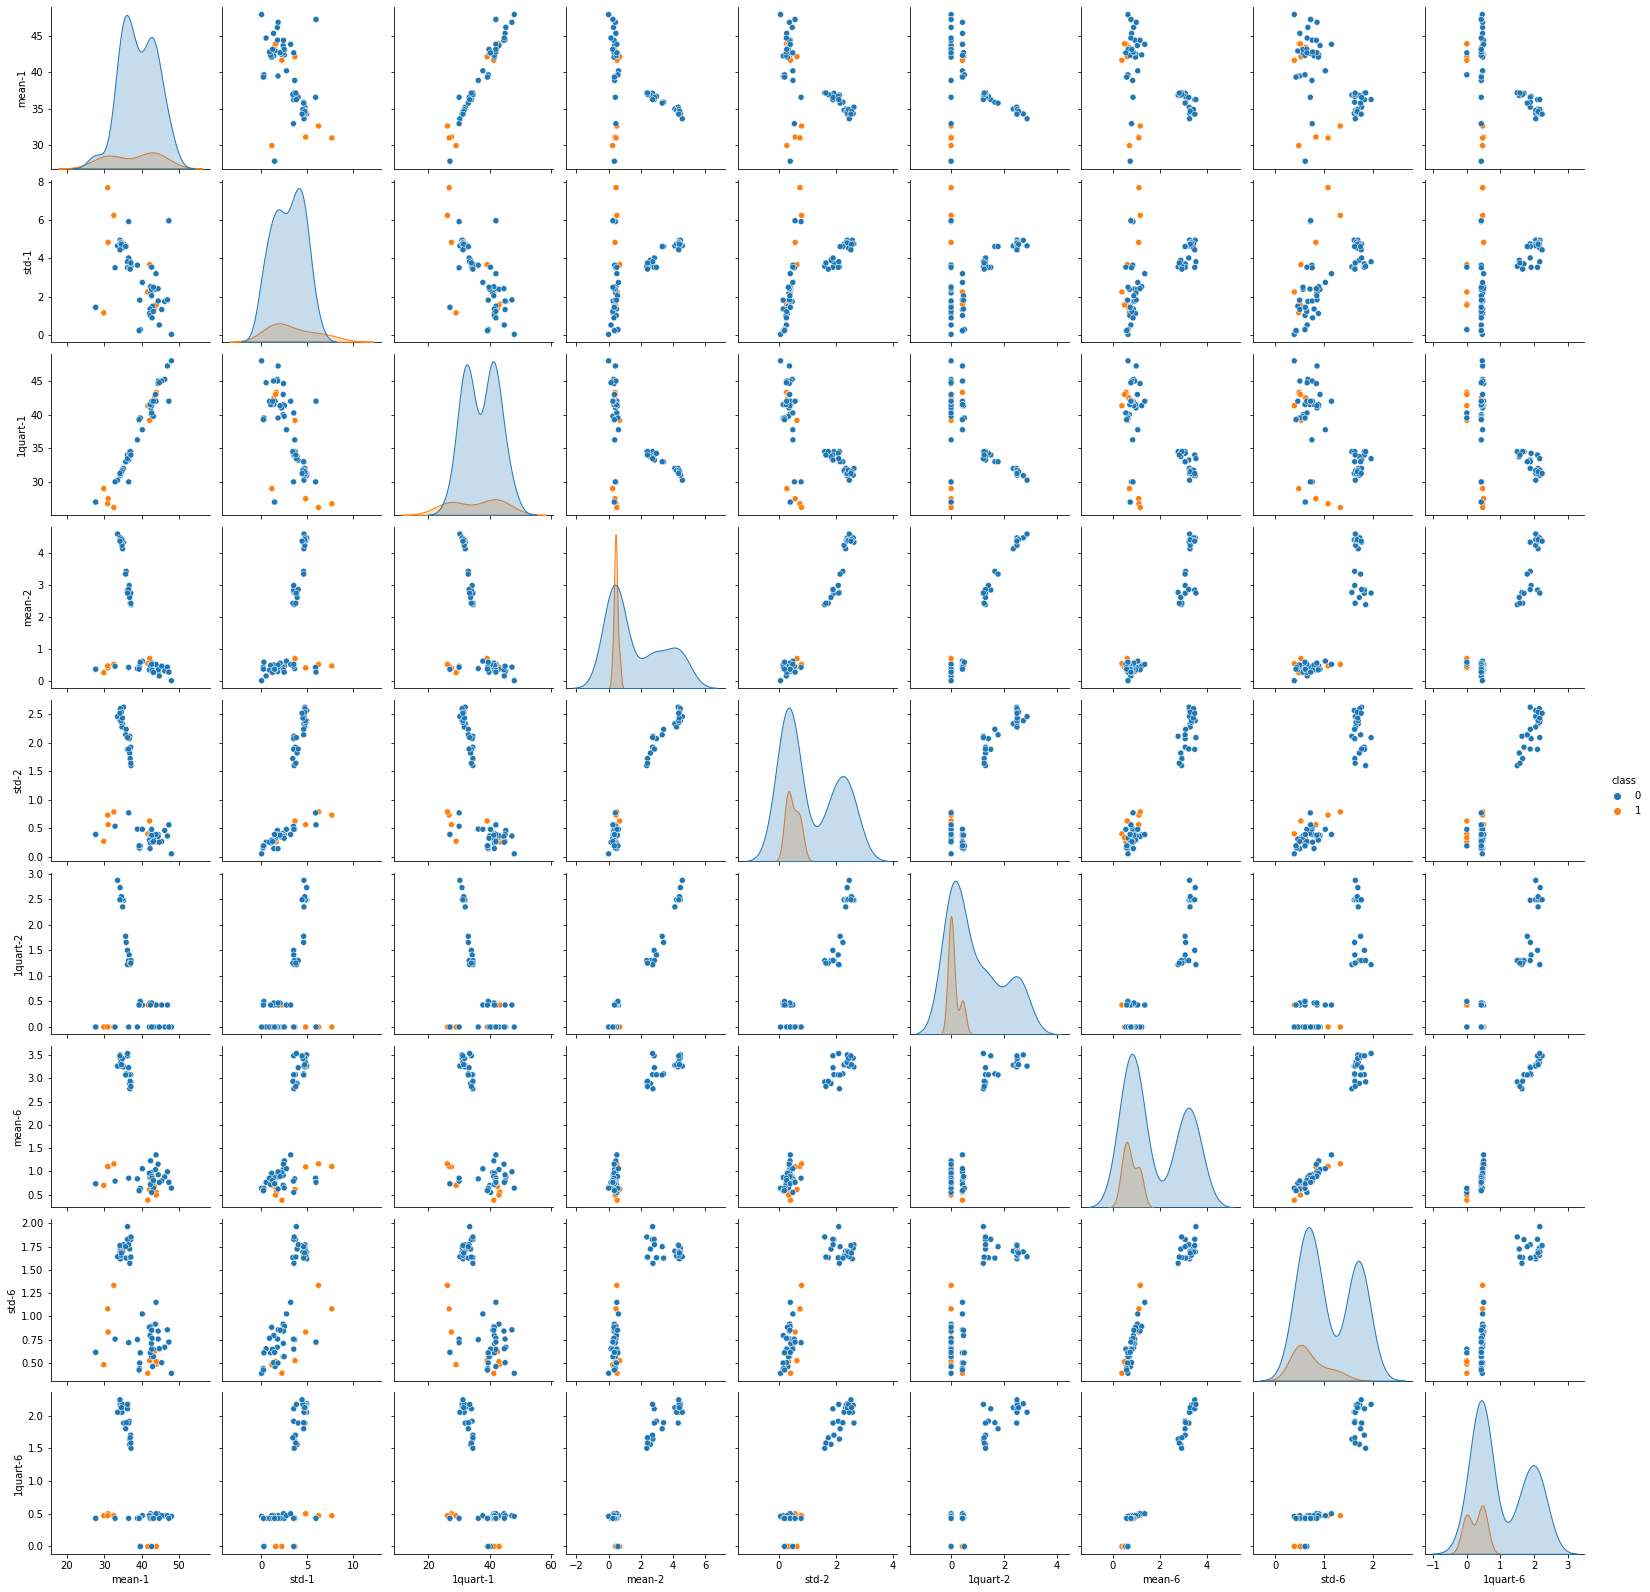

In [11]:
sns.pairplot(train_df, hue='class') # bending = class 1, other = class 0

# Question (2) (a) (ii)

In [12]:
l = 2
df_headers = ['activity', 'dataset']
df_features = ['min', 'max', 'mean', 'median', 'std', '1quart', '3quart']
for i in range(6):
    for j in range(len(df_features)):
        for k in range(l):
            df_headers.append(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))

In [13]:
df = pd.DataFrame(columns=df_headers)

for root, dirs, files in os.walk('../data/ARem'):
    for filename in files:
        if 'csv' in filename:
            df_row = []
            activity = root.replace('../data/ARem/', '') # activity
            dataset = filename.replace('.csv', '') # dataset
            df_row.extend((activity, dataset))
            # print(df_row)
            
            seperator = ','
            if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '
                
            path = os.path.join(root, filename)
            df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)
            
            num_rows = math.floor(len(df_instance) / l)
            for i in range(6):
                for j in range(len(df_features)):
                    for k in range(l):
                        # print(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
                        if ('min' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].min()[i + 1])
                        if ('max' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].max()[i + 1])
                        if ('mean' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].mean()[i + 1])
                        if ('median' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].median()[i + 1])
                        if ('std' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].std()[i + 1])
                        if ('1quart' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.25)[i + 1])
                        if ('3quart' in df_features[j]):
                            df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.75)[i + 1])
            df.loc[len(df.index)] = df_row


In [14]:
test_train = []
for i in range(len(df)):
    if ('dataset1' == df['dataset'][i] or 'dataset2' == df['dataset'][i]):
        test_train.append('test')
    elif ('dataset3' == df['dataset'][i] and 'bending1' != df['activity'][i] and 'bending2' != df['activity'][i]):
        test_train.append('test')
    else:
        test_train.append('train')

df['dataset'] = test_train

classification = []
for i in range(len(df)):
    if ('bending' in df['activity'][i]):
        classification.append(1)
    else:
        classification.append(0)

df['class'] = classification

In [15]:
train_df = df[df['dataset'] == 'train'][['mean 1-1', 'mean 1-2', 'std 1-1', 'std 1-2', '1quart 1-1', '1quart 1-2', 'mean 2-1', 'mean 2-2', 'std 2-1', 'std 2-2', '1quart 2-1', '1quart 2-2', 'mean 6-1', 'mean 6-2', 'std 6-1', 'std 6-2', '1quart 6-1', '1quart 6-2', 'class']]

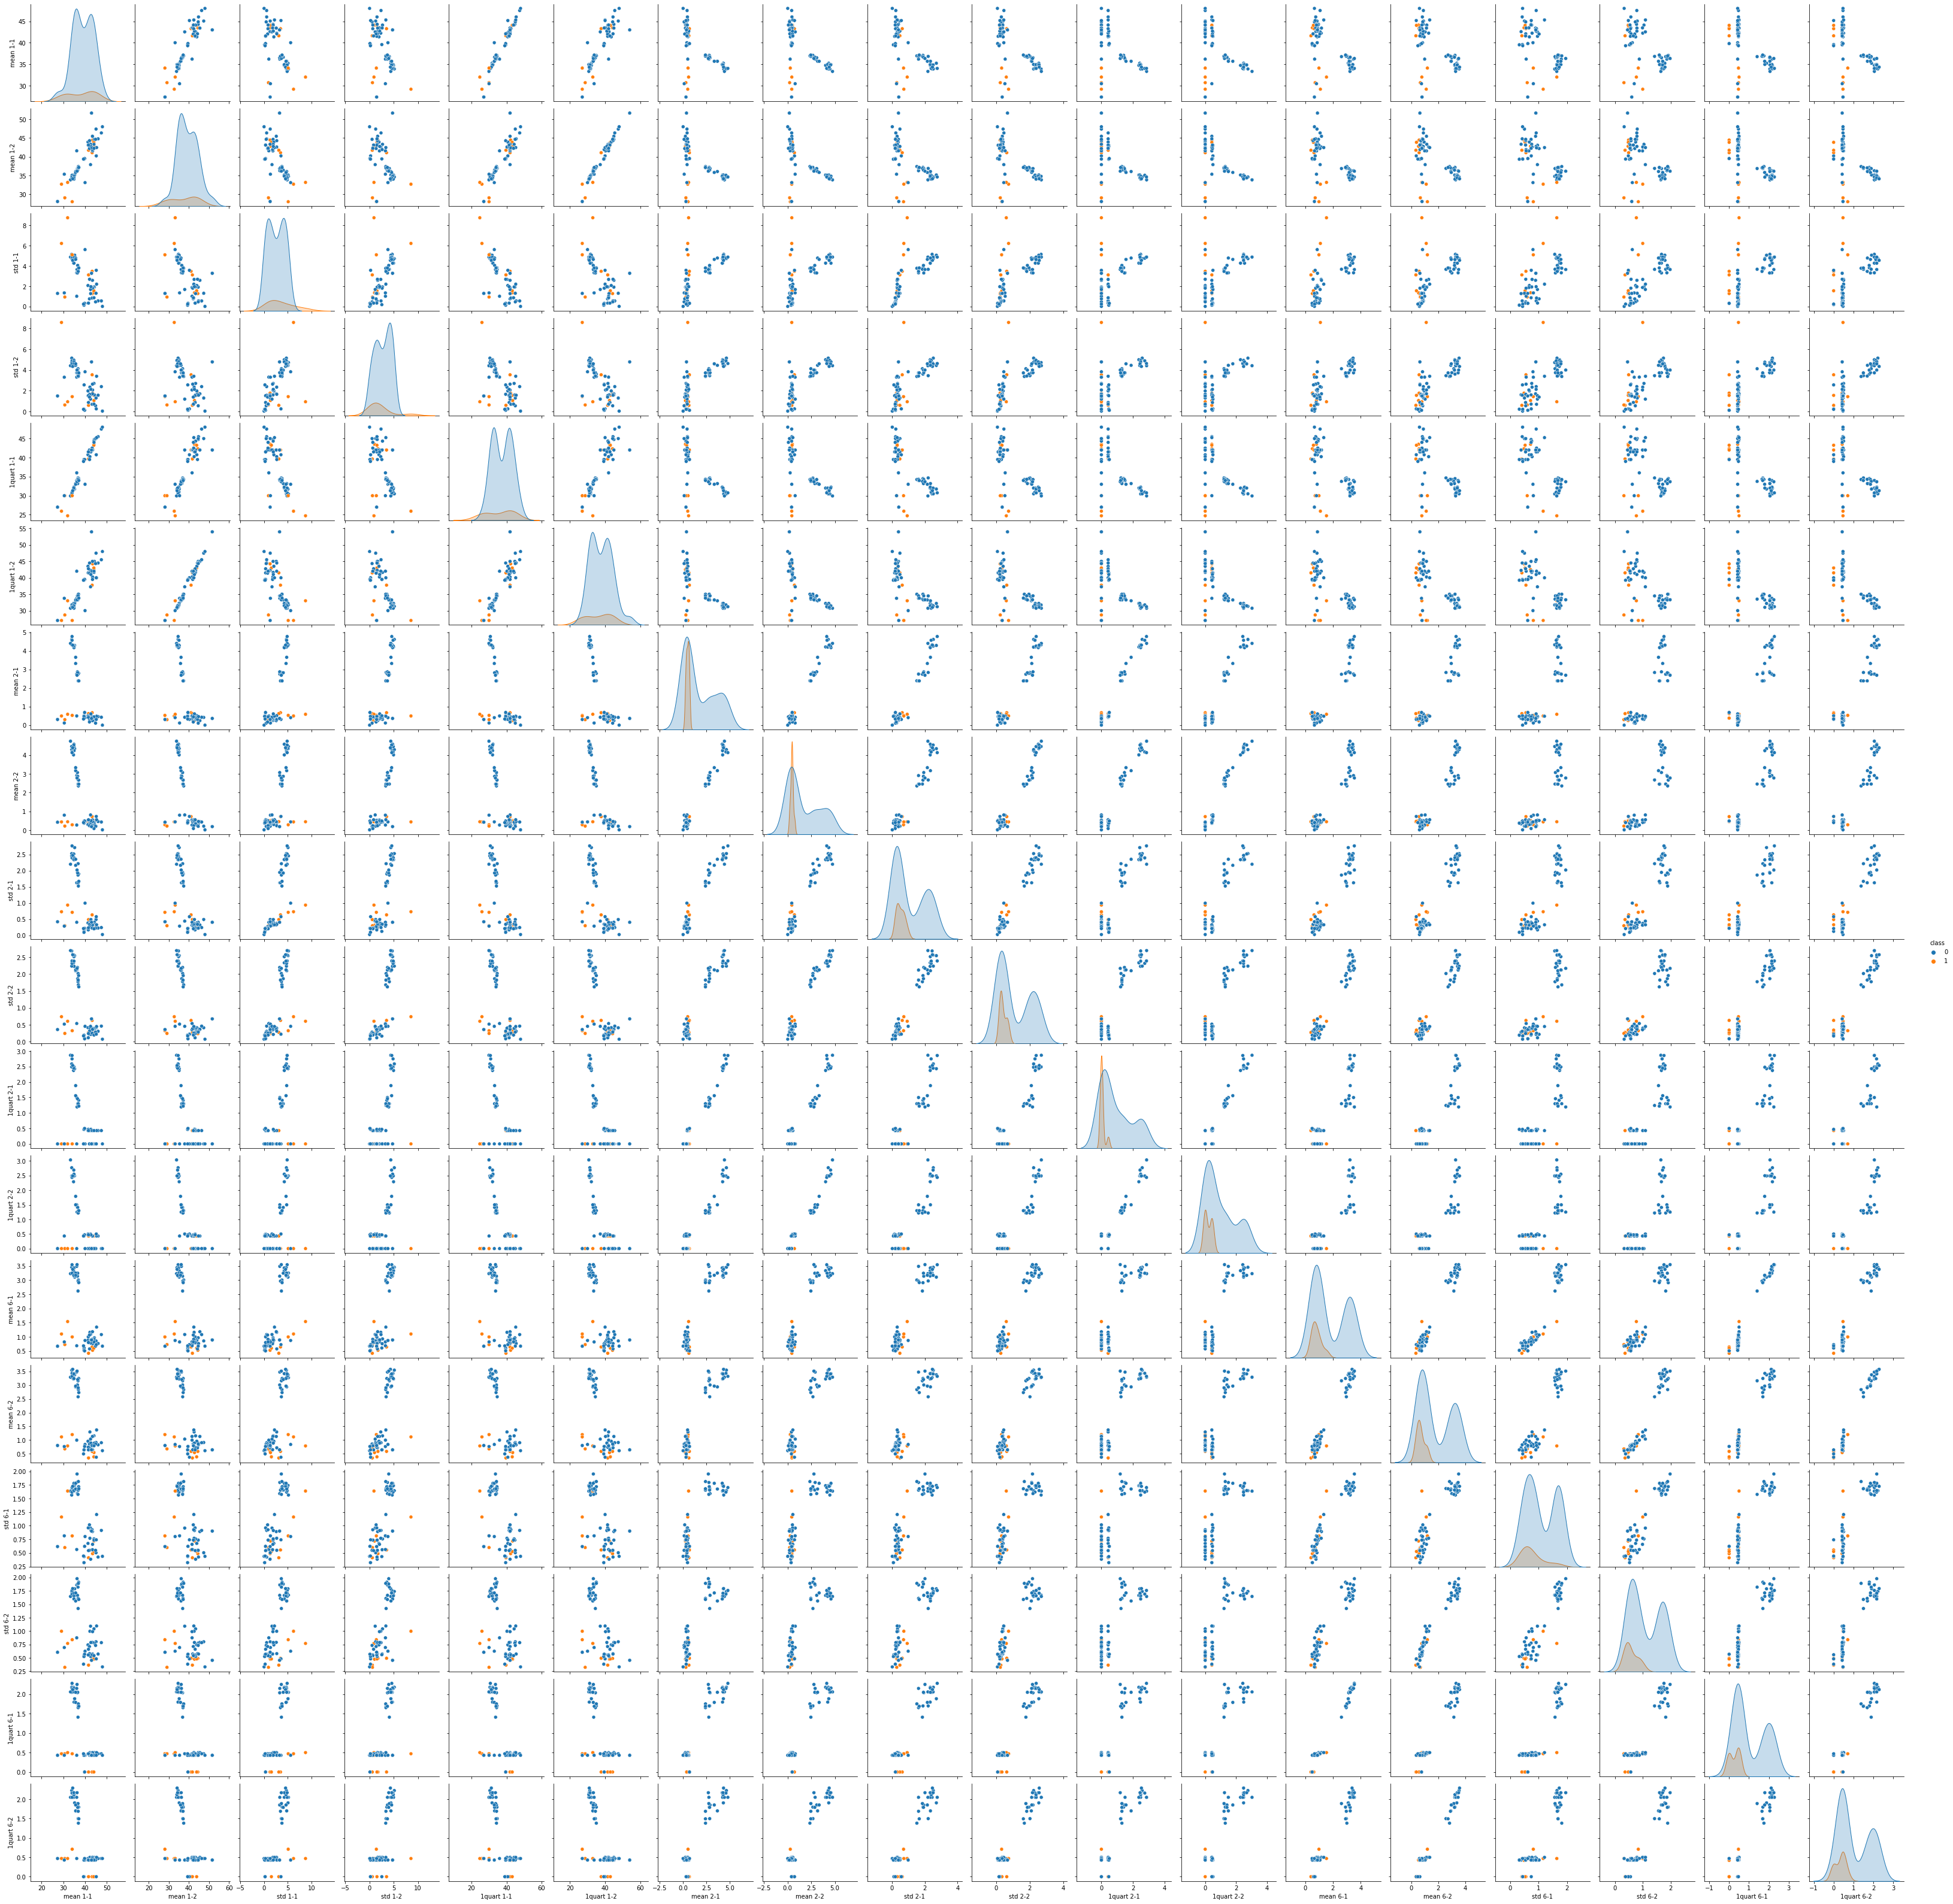

In [16]:
sns.pairplot(train_df, hue='class') # bending = class 1, other = class 0

No, I do not see any considerable differences compared to the results of 2(a)(i). Now that we have twice as many features, it is possible that some of the scatter plots have more distinct seperation between class 0 and 1, but it is not obvious due to large amount of scatter plots.

# Question (2) (a) (iii)

In [17]:
df_list = []
for i in range(20):
    df_list.append(pd.DataFrame())

In [18]:
print('Dataset Creation with Breaks 1 to 20, Time Series 1 to 6, and Features Mean Std and 1st Quartile')
print()

for l in range(1, 21):
    df_headers = ['activity', 'dataset']
    df_features = ['mean', 'std', '1quart']
    # df_features = ['min', 'max', 'mean', 'median', 'std', '1quart', '3quart']
    for i in range(6):
        for j in range(len(df_features)):
            for k in range(l):
                df_headers.append(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
    
    df = pd.DataFrame(columns=df_headers)

    for root, dirs, files in os.walk('../data/ARem'):
        for filename in files:
            if 'csv' in filename:
                df_row = []
                activity = root.replace('../data/ARem/', '') # activity
                dataset = filename.replace('.csv', '') # dataset
                df_row.extend((activity, dataset))
                # print(df_row)

                seperator = ','
                if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '

                path = os.path.join(root, filename)
                df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)

                num_rows = math.floor(len(df_instance) / l)
                for i in range(6):
                    for j in range(len(df_features)):
                        for k in range(l):
                            # print(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
                            if ('min' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].min()[i + 1])
                            if ('max' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].max()[i + 1])
                            if ('mean' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].mean()[i + 1])
                            if ('median' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].median()[i + 1])
                            if ('std' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].std()[i + 1])
                            if ('1quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.25)[i + 1])
                            if ('3quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.75)[i + 1])
                df.loc[len(df.index)] = df_row
    df_list[l - 1] = df
    print('Dataset (l=' + str(l) + '), Size=' + str(df.shape))

Dataset Creation with Breaks 1 to 20, Time Series 1 to 6, and Features Mean Std and 1st Quartile

Dataset (l=1), Size=(88, 20)
Dataset (l=2), Size=(88, 38)
Dataset (l=3), Size=(88, 56)
Dataset (l=4), Size=(88, 74)
Dataset (l=5), Size=(88, 92)
Dataset (l=6), Size=(88, 110)
Dataset (l=7), Size=(88, 128)
Dataset (l=8), Size=(88, 146)
Dataset (l=9), Size=(88, 164)
Dataset (l=10), Size=(88, 182)
Dataset (l=11), Size=(88, 200)
Dataset (l=12), Size=(88, 218)
Dataset (l=13), Size=(88, 236)
Dataset (l=14), Size=(88, 254)
Dataset (l=15), Size=(88, 272)
Dataset (l=16), Size=(88, 290)
Dataset (l=17), Size=(88, 308)
Dataset (l=18), Size=(88, 326)
Dataset (l=19), Size=(88, 344)
Dataset (l=20), Size=(88, 362)


In [19]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

df_train_list = []
df_test_list = []
for df in df_list:
    test_train = []
    for i in range(len(df)):
        if ('dataset1' == df['dataset'][i] or 'dataset2' == df['dataset'][i]):
            test_train.append('test')
        elif ('dataset3' == df['dataset'][i] and 'bending1' != df['activity'][i] and 'bending2' != df['activity'][i]):
            test_train.append('test')
        else:
            test_train.append('train')

    df['dataset'] = test_train

    classification = []
    for i in range(len(df)):
        if ('bending' in df['activity'][i]):
            classification.append(1)
        else:
            classification.append(0)

    df['class'] = classification
    df_train_list.append(df[df['dataset'] == 'train'].drop(columns=['activity', 'dataset']))
    df_test_list.append(df[df['dataset'] == 'test'].drop(columns=['activity', 'dataset']))

In [20]:
print('Recursive Feature Elimination')
print()

for i in range(len(df_train_list)):
    model = LogisticRegression(C=float('inf'), max_iter=1000)
    selector = RFECV(model, cv=StratifiedKFold(5), scoring='accuracy')
    selector = selector.fit(df_train_list[i].iloc[:, :-1], df_train_list[i]['class'])
    drop_columns = []
    for j in range(len(selector.support_)):
        if (not selector.support_[j]): drop_columns.append(j)
    df_train_list[i] = df_train_list[i].drop(columns=df_train_list[i].columns[drop_columns])
    df_test_list[i] = df_test_list[i].drop(columns=df_test_list[i].columns[drop_columns])
    print('Train Dataset l=' + str(i + 1) + ', Size=' + str(df_train_list[i].shape) + ', Dropped ' + str(len(drop_columns)) + ' Features, p=' + str(df_train_list[i].shape[1] - 1))
    # print(' Test Dataset l=' + str(i + 1) + ', Size=' + str(df_test_list[i].shape) + ', Dropped ' + str(len(drop_columns)) + ' Columns')

Recursive Feature Elimination

Train Dataset l=1, Size=(69, 10), Dropped 9 Features, p=9
Train Dataset l=2, Size=(69, 33), Dropped 4 Features, p=32
Train Dataset l=3, Size=(69, 3), Dropped 52 Features, p=2
Train Dataset l=4, Size=(69, 13), Dropped 60 Features, p=12
Train Dataset l=5, Size=(69, 9), Dropped 82 Features, p=8
Train Dataset l=6, Size=(69, 28), Dropped 81 Features, p=27
Train Dataset l=7, Size=(69, 10), Dropped 117 Features, p=9
Train Dataset l=8, Size=(69, 5), Dropped 140 Features, p=4
Train Dataset l=9, Size=(69, 4), Dropped 159 Features, p=3
Train Dataset l=10, Size=(69, 9), Dropped 172 Features, p=8
Train Dataset l=11, Size=(69, 8), Dropped 191 Features, p=7
Train Dataset l=12, Size=(69, 3), Dropped 214 Features, p=2
Train Dataset l=13, Size=(69, 4), Dropped 231 Features, p=3
Train Dataset l=14, Size=(69, 7), Dropped 246 Features, p=6
Train Dataset l=15, Size=(69, 8), Dropped 263 Features, p=7
Train Dataset l=16, Size=(69, 4), Dropped 285 Features, p=3
Train Dataset l=17

In [21]:
print('Logistic Regression with Recursive Feature Elimation')
print()

l = 0
for df in df_train_list:
    l += 1
    model = LogisticRegression(C=float('inf'))
    scores = cross_val_score(model, df.iloc[:, :-1], df['class'], cv=StratifiedKFold(5), scoring='accuracy')
    print('Train Dataset (l=' + str(l) + ', p=' + str(df.shape[1] - 1) + '), Accuracy=' + str(scores.mean()))

Logistic Regression with Recursive Feature Elimation

Train Dataset (l=1, p=9), Accuracy=0.9285714285714286
Train Dataset (l=2, p=32), Accuracy=0.9
Train Dataset (l=3, p=2), Accuracy=0.9714285714285715
Train Dataset (l=4, p=12), Accuracy=0.9714285714285715
Train Dataset (l=5, p=8), Accuracy=0.9714285714285715
Train Dataset (l=6, p=27), Accuracy=0.9571428571428571
Train Dataset (l=7, p=9), Accuracy=0.9857142857142858
Train Dataset (l=8, p=4), Accuracy=1.0
Train Dataset (l=9, p=3), Accuracy=0.9714285714285715
Train Dataset (l=10, p=8), Accuracy=0.9857142857142858
Train Dataset (l=11, p=7), Accuracy=1.0
Train Dataset (l=12, p=2), Accuracy=0.9571428571428571
Train Dataset (l=13, p=3), Accuracy=0.9857142857142858
Train Dataset (l=14, p=6), Accuracy=0.9714285714285715
Train Dataset (l=15, p=7), Accuracy=1.0
Train Dataset (l=16, p=3), Accuracy=1.0
Train Dataset (l=17, p=3), Accuracy=1.0
Train Dataset (l=18, p=4), Accuracy=0.9857142857142858
Train Dataset (l=19, p=4), Accuracy=1.0
Train Datase

Optimal (l, p) is (8, 4) with an accuracy of 1.0. The correct way to do cross validation is to use feature elimation to remove p columns for every dataset(l) 1 to 20. Then use cross validation to score each dataset(l) (with p features removed) with a new model and choose the best one. The incorrect way would be to use cross validation to score each dataset(l) 1 to 20 and choose the best one. After finding the highest scoring dataset(l), use feature elimation to remove p features for that dataset(l).

# Question (2) (a) (iv)

Logistic Regression with Recursive Feature Elimation Using Optimal (l, p) Training Data

Accuracy: 1.0

Confusion Matrix:
[[60  0]
 [ 0  9]]

ROC: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x28d63a9d0>


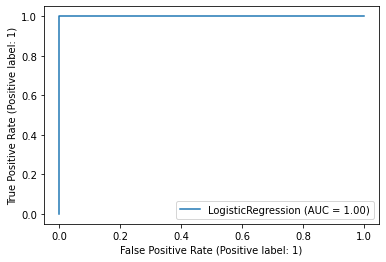

In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)

X_train = df_train_list[7].iloc[:, :-1]
Y_train = df_train_list[7]['class']

model = LogisticRegression(C=float('inf')).fit(X_train, Y_train)
Y_pred = model.predict(X_train)

print('Logistic Regression with Recursive Feature Elimation Using Optimal (l, p) Training Data')
print()
print('Accuracy:', model.score(X_train, Y_train))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_train, Y_pred))
print()
print('ROC:', plot_roc_curve(model, X_train, Y_train))

In [23]:
model = sm.OLS(Y_train, sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  class   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     27.27
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           3.17e-13
Time:                        14:30:31   Log-Likelihood:                 11.507
No. Observations:                  69   AIC:                            -13.01
Df Residuals:                      64   BIC:                            -1.844
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4872      0.246      1.977      0.0

# Question (2) (a) (v)

In [24]:
X_train = df_train_list[7].iloc[:, :-1]
Y_train = df_train_list[7]['class']
X_test = df_test_list[7].iloc[:, :-1]
Y_test = df_test_list[7]['class']

model = LogisticRegression(C=float('inf')).fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print('Logistic Regression Model with Recursive Feature Elimation and Testing Data')
print()
print('Accuracy:', model.score(X_test, Y_test))

Logistic Regression Model with Recursive Feature Elimation and Testing Data

Accuracy: 0.9473684210526315


Comparing the accuracy on the test set (0.94) with the cross-validation accuracy you obtained previously (1.0), the logistic regression model scored worse on the test set with cross-validation on the training set. This is expected as the model was built using the cross-validated training set, so it should logically perform well (perfect) when trying to predict classes of instances it was trained with. The accuracy of the test set was lower because the model has to predict the classes of data it has not seen before, which varies from the training set data it was trained with. However 0.94 accuracy with test set is still good so it helps confirm that we did not overfit or badly train the model.

# Question (2) (a) (vi)

No, my classes do not cause instability in calculating logistic regression parameters. I confirmed this by running my feature selection code multiple times, and coming up with the same logistic regression parameters each time. This means that the calculation of logistic regression parameters is stable. I ensured this by modifying the 'max-iter' parameter in my logistic regression model to stop the algorithm immaturely and prevent from its instability.

# Question (2) (a) (vii)

Yes, from the confusion matrices I obtained in (2)(a)(iv) I see imbalanced classess. After running the logistic regression model again based on case-control sampling and adjusted parameters, the classes became less imbalanced.

Logistic Regression with Recursive Feature Elimation and Case-Controlled Sampling

Train Accuracy: 1.0

Train Confusion Matrix:
[[60  0]
 [ 0 60]]

Train ROC: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x292415700>


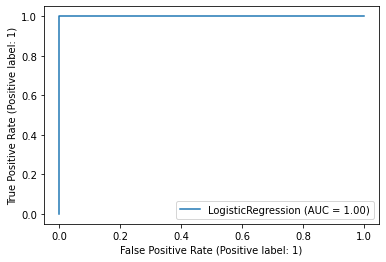

In [25]:
X_train = df_train_list[7].iloc[:, :-1]
Y_train = df_train_list[7]['class']

smote = SMOTE()
X_train, Y_train = smote.fit_resample(X_train, Y_train)

X_test = df_test_list[7].iloc[:, :-1]
Y_test = df_test_list[7]['class']

model = LogisticRegression(C=float('inf')).fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print('Logistic Regression with Recursive Feature Elimation and Case-Controlled Sampling')
print()
print('Train Accuracy:', model.score(X_train, Y_train))
print()
print('Train Confusion Matrix:')
print(confusion_matrix(Y_train, model.predict(X_train)))
print()
print('Train ROC:', plot_roc_curve(model, X_train, Y_train))


Test Accuracy: 0.8947368421052632

Test Confusion Matrix:
[[13  2]
 [ 0  4]]

Test ROC: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x28a9491c0>


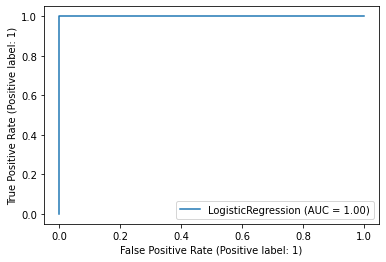

In [26]:
print()
print('Test Accuracy:', model.score(X_test, Y_test))
print()
print('Test Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))
print()
print('Test ROC:', plot_roc_curve(model, X_test, Y_test))

# Question (2) (b) (i)

In [27]:
df_list = []
for i in range(20):
    df_list.append(pd.DataFrame())

In [28]:
for l in range(1, 21):
    df_headers = ['activity', 'dataset']
    df_features = ['mean', 'std', '1quart']
    # df_features = ['min', 'max', 'mean', 'median', 'std', '1quart', '3quart']
    for i in range(6):
        for j in range(len(df_features)):
            for k in range(l):
                df_headers.append(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
    
    df = pd.DataFrame(columns=df_headers)

    for root, dirs, files in os.walk('../data/ARem'):
        for filename in files:
            if 'csv' in filename:
                df_row = []
                activity = root.replace('../data/ARem/', '') # activity
                dataset = filename.replace('.csv', '') # dataset
                df_row.extend((activity, dataset))
                # print(df_row)

                seperator = ','
                if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '

                path = os.path.join(root, filename)
                df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)

                num_rows = math.floor(len(df_instance) / l)
                for i in range(6):
                    for j in range(len(df_features)):
                        for k in range(l):
                            # print(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
                            if ('min' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].min()[i + 1])
                            if ('max' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].max()[i + 1])
                            if ('mean' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].mean()[i + 1])
                            if ('median' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].median()[i + 1])
                            if ('std' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].std()[i + 1])
                            if ('1quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.25)[i + 1])
                            if ('3quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.75)[i + 1])
                df.loc[len(df.index)] = df_row
    df_list[l - 1] = df
    # print('Dataset l=' + str(l) + ', Size=' + str(df.shape))

In [29]:
df_train_list = []
df_test_list = []
for df in df_list:
    test_train = []
    for i in range(len(df)):
        if ('dataset1' == df['dataset'][i] or 'dataset2' == df['dataset'][i]):
            test_train.append('test')
        elif ('dataset3' == df['dataset'][i] and 'bending1' != df['activity'][i] and 'bending2' != df['activity'][i]):
            test_train.append('test')
        else:
            test_train.append('train')

    df['dataset'] = test_train

    classification = []
    for i in range(len(df)):
        if ('bending' in df['activity'][i]):
            classification.append(1)
        else:
            classification.append(0)

    df['class'] = classification
    df_train_list.append(df[df['dataset'] == 'train'].drop(columns=['activity', 'dataset']))
    df_test_list.append(df[df['dataset'] == 'test'].drop(columns=['activity', 'dataset']))

In [30]:
print('L1 Penalized Logistic Regression with Cross Validation')
print()

l = 0
for df in df_train_list:
    l += 1
    X_train = df.iloc[:, :-1]
    Y_train = df['class']
    model = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', scoring='accuracy', solver='liblinear')
    model = model.fit(X_train, Y_train)
    # scores = cross_val_score(model, X_train, Y_train, cv=StratifiedKFold(5), scoring='accuracy')
    # print('Train Dataset (l=' + str(l) + ', p=' + str(model.n_features_in_) + ', C=' + str(model.C_[0]) + '), Accuracy=' + str(scores.mean()))
    # print(model.score(X_train, Y_train))
    print('Train Dataset (l=' + str(l) + ', p=' + str(model.n_features_in_) + ')' + ', C=' + str(model.C_[0]) + ', Accuracy=' + str(model.score(X_train, Y_train)))

L1 Penalized Logistic Regression with Cross Validation

Train Dataset (l=1, p=18), C=0.3593813663804626, Accuracy=0.9565217391304348
Train Dataset (l=2, p=36), C=0.3593813663804626, Accuracy=0.9855072463768116
Train Dataset (l=3, p=54), C=2.782559402207126, Accuracy=1.0
Train Dataset (l=4, p=72), C=2.782559402207126, Accuracy=1.0
Train Dataset (l=5, p=90), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=6, p=108), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=7, p=126), C=1291.5496650148827, Accuracy=1.0
Train Dataset (l=8, p=144), C=21.54434690031882, Accuracy=1.0
Train Dataset (l=9, p=162), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=10, p=180), C=2.782559402207126, Accuracy=1.0
Train Dataset (l=11, p=198), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=12, p=216), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=13, p=234), C=0.3593813663804626, Accuracy=1.0
Train Dataset (l=14, p=252), C=0.046415888336127774, Accuracy=0.9420289855072463
Train Dataset (l=15

# Question (2) (b) (ii)

L1 penalized logistic regression performs better than variable selection using p-values. In my project, L1 penalized logistic regression got 100% accuracy on 16/20 training datasets, while variable selection using p-values only got 100% accuracy on 6/20 training datasets. L1 penalized logistic regression was also easier to implement, mostly because a lot of the work required is taken care of by the sklearn.linear_model.LogisticRegressionCV package. In comparison, variable selection using p-values required more manual work to construct 20 datasets, use sklearn.feature_selection.RFECV on each of the 20 datasets to prune features before using the optimal datasets, then finally rerun logistic regression on the pruned datasets to determine overall performance and accuracy.

# Question (2) (c) (i)

In [31]:
df_list = []
for i in range(20):
    df_list.append(pd.DataFrame())

In [32]:
for l in range(1, 21):
    df_headers = ['activity', 'dataset']
    df_features = ['mean', 'std', '1quart']
    # df_features = ['min', 'max', 'mean', 'median', 'std', '1quart', '3quart']
    for i in range(6):
        for j in range(len(df_features)):
            for k in range(l):
                df_headers.append(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
    
    df = pd.DataFrame(columns=df_headers)

    for root, dirs, files in os.walk('../data/ARem'):
        for filename in files:
            if 'csv' in filename:
                df_row = []
                activity = root.replace('../data/ARem/', '') # activity
                dataset = filename.replace('.csv', '') # dataset
                df_row.extend((activity, dataset))
                # print(df_row)

                seperator = ','
                if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '

                path = os.path.join(root, filename)
                df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)

                num_rows = math.floor(len(df_instance) / l)
                for i in range(6):
                    for j in range(len(df_features)):
                        for k in range(l):
                            # print(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
                            if ('min' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].min()[i + 1])
                            if ('max' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].max()[i + 1])
                            if ('mean' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].mean()[i + 1])
                            if ('median' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].median()[i + 1])
                            if ('std' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].std()[i + 1])
                            if ('1quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.25)[i + 1])
                            if ('3quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.75)[i + 1])
                df.loc[len(df.index)] = df_row
    df_list[l - 1] = df
    # print('Dataset l=' + str(l) + ', Size=' + str(df.shape))

In [33]:
df_train_list = []
df_test_list = []
for df in df_list:
    test_train = []
    for i in range(len(df)):
        if ('dataset1' == df['dataset'][i] or 'dataset2' == df['dataset'][i]):
            test_train.append('test')
        elif ('dataset3' == df['dataset'][i] and 'bending1' != df['activity'][i] and 'bending2' != df['activity'][i]):
            test_train.append('test')
        else:
            test_train.append('train')

    df['dataset'] = test_train

    classification = []
    for i in range(len(df)):
        if ('bending' in df['activity'][i]):
            classification.append('bending')
        else:
            classification.append(df['activity'][i])

    df['class'] = classification
    df_train_list.append(df[df['dataset'] == 'train'].drop(columns=['activity', 'dataset']))
    df_test_list.append(df[df['dataset'] == 'test'].drop(columns=['activity', 'dataset']))

In [34]:
print('L1 Penalized Multinomial Logistic Regression')
print()

l = 0
for df in df_train_list:
    l += 1
    X_train = df.iloc[:, :-1]
    Y_train = df['class']
    model = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', scoring='accuracy', solver='liblinear', max_iter=1000)
    model = model.fit(X_train, Y_train)
    # scores = cross_val_score(model, X_train, Y_train, cv=StratifiedKFold(5), scoring='accuracy')
    # print('Train Dataset (l=' + str(l) + ', p=' + str(model.n_features_in_) + '), Accuracy=' + str(scores.mean()))
    print('Train Dataset (l=' + str(l) + ', p=' + str(model.n_features_in_) + ')' + ', Accuracy=' + str(model.score(X_train, Y_train)))
    print('Cs=' + str(model.C_))

L1 Penalized Multinomial Logistic Regression

Train Dataset (l=1, p=18), Accuracy=0.9565217391304348
Cs=[3.59381366e-01 2.78255940e+00 1.29154967e+03 2.78255940e+00
 2.78255940e+00 3.59381366e-01]
Train Dataset (l=2, p=36), Accuracy=1.0
Cs=[ 0.35938137  2.7825594  21.5443469   2.7825594   0.35938137  0.35938137]
Train Dataset (l=3, p=54), Accuracy=1.0
Cs=[1.29154967e+03 1.66810054e+02 3.59381366e-01 2.15443469e+01
 3.59381366e-01 3.59381366e-01]
Train Dataset (l=4, p=72), Accuracy=1.0
Cs=[2.78255940e+00 1.29154967e+03 3.59381366e-01 1.29154967e+03
 1.66810054e+02 3.59381366e-01]
Train Dataset (l=5, p=90), Accuracy=1.0
Cs=[2.78255940e+00 1.66810054e+02 3.59381366e-01 1.29154967e+03
 2.78255940e+00 2.78255940e+00]
Train Dataset (l=6, p=108), Accuracy=1.0
Cs=[2.78255940e+00 2.15443469e+01 3.59381366e-01 1.00000000e+04
 1.29154967e+03 3.59381366e-01]
Train Dataset (l=7, p=126), Accuracy=1.0
Cs=[3.59381366e-01 1.66810054e+02 3.59381366e-01 2.15443469e+01
 1.29154967e+03 3.59381366e-01]
Trai

In [35]:
X_train = df_train_list[1].iloc[:, :-1]
Y_train = df_train_list[1]['class']
X_test = df_test_list[1].iloc[:, :-1]
Y_test = df_test_list[1]['class']

model = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', scoring='accuracy', solver='liblinear', max_iter=1000)
model = model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print('L1 Penalized Multinomial Logistic Regression with Testing Data (l=2)')
print()
print('Test Error:', 1 - model.score(X_test, Y_test))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))
print()
# print('ROC:', plot_roc_curve(model, X_train, Y_train))

L1 Penalized Multinomial Logistic Regression with Testing Data (l=2)

Test Error: 0.052631578947368474

Confusion Matrix:
[[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]



# Question (2) (c) (ii)

In [36]:
df_list = []
for i in range(20):
    df_list.append(pd.DataFrame())

In [37]:
for l in range(1, 21):
    df_headers = ['activity', 'dataset']
    df_features = ['mean', 'std', '1quart']
    # df_features = ['min', 'max', 'mean', 'median', 'std', '1quart', '3quart']
    for i in range(6):
        for j in range(len(df_features)):
            for k in range(l):
                df_headers.append(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
    
    df = pd.DataFrame(columns=df_headers)

    for root, dirs, files in os.walk('../data/ARem'):
        for filename in files:
            if 'csv' in filename:
                df_row = []
                activity = root.replace('../data/ARem/', '') # activity
                dataset = filename.replace('.csv', '') # dataset
                df_row.extend((activity, dataset))
                # print(df_row)

                seperator = ','
                if (activity == 'bending2') and (dataset == 'dataset4'): seperator = ' '

                path = os.path.join(root, filename)
                df_instance = pd.read_csv(path, skiprows=5, header=None, sep=seperator)

                num_rows = math.floor(len(df_instance) / l)
                for i in range(6):
                    for j in range(len(df_features)):
                        for k in range(l):
                            # print(df_features[j] + ' ' + str(i + 1) + '-' + str(k + 1))
                            if ('min' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].min()[i + 1])
                            if ('max' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].max()[i + 1])
                            if ('mean' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].mean()[i + 1])
                            if ('median' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].median()[i + 1])
                            if ('std' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].std()[i + 1])
                            if ('1quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.25)[i + 1])
                            if ('3quart' in df_features[j]):
                                df_row.append(df_instance[k * num_rows : (k + 1) * num_rows].quantile(0.75)[i + 1])
                df.loc[len(df.index)] = df_row
    df_list[l - 1] = df
    # print('Dataset l=' + str(l) + ', Size=' + str(df.shape))

In [38]:
print('Gaussian Naive Bayes')
print()

l = 0
for df in df_train_list:
    l += 1
    X_train = df.iloc[:, :-1]
    Y_train = df['class']
    model = GaussianNB()
    # model = model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=StratifiedKFold(5), scoring='accuracy')
    print('Train Dataset (l=' + str(l) + ', p=' + str(df.shape[1] - 1) + '), Accuracy=' + str(scores.mean()))
    # print('Train Dataset (l=' + str(l) + '), Accuracy=' + str(model.score(X_train, Y_train)))

Gaussian Naive Bayes

Train Dataset (l=1, p=18), Accuracy=0.7791208791208791
Train Dataset (l=2, p=36), Accuracy=0.7978021978021979
Train Dataset (l=3, p=54), Accuracy=0.7538461538461538
Train Dataset (l=4, p=72), Accuracy=0.7395604395604395
Train Dataset (l=5, p=90), Accuracy=0.7967032967032968
Train Dataset (l=6, p=108), Accuracy=0.754945054945055
Train Dataset (l=7, p=126), Accuracy=0.7824175824175825
Train Dataset (l=8, p=144), Accuracy=0.7098901098901098
Train Dataset (l=9, p=162), Accuracy=0.7681318681318682
Train Dataset (l=10, p=180), Accuracy=0.7098901098901098
Train Dataset (l=11, p=198), Accuracy=0.7813186813186814
Train Dataset (l=12, p=216), Accuracy=0.7241758241758243
Train Dataset (l=13, p=234), Accuracy=0.7516483516483516
Train Dataset (l=14, p=252), Accuracy=0.7373626373626374
Train Dataset (l=15, p=270), Accuracy=0.7384615384615385
Train Dataset (l=16, p=288), Accuracy=0.7813186813186812
Train Dataset (l=17, p=306), Accuracy=0.767032967032967
Train Dataset (l=18, p=32

In [39]:
print('Multinomial Naive Bayes')
print()

l = 0
for df in df_train_list:
    l += 1
    X_train = df.iloc[:, :-1]
    Y_train = df['class']
    model = MultinomialNB()
    # model = model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=StratifiedKFold(5), scoring='accuracy')
    print('Train Dataset (l=' + str(l) + ', p=' + str(df.shape[1] - 1) + '), Accuracy=' + str(scores.mean()))
    # print('Train Dataset (l=' + str(l) + '), Accuracy=' + str(model.score(X_train, Y_train)))

Multinomial Naive Bayes

Train Dataset (l=1, p=18), Accuracy=0.7692307692307693
Train Dataset (l=2, p=36), Accuracy=0.7681318681318682
Train Dataset (l=3, p=54), Accuracy=0.7978021978021979
Train Dataset (l=4, p=72), Accuracy=0.7681318681318682
Train Dataset (l=5, p=90), Accuracy=0.8274725274725274
Train Dataset (l=6, p=108), Accuracy=0.8120879120879121
Train Dataset (l=7, p=126), Accuracy=0.7835164835164836
Train Dataset (l=8, p=144), Accuracy=0.8120879120879121
Train Dataset (l=9, p=162), Accuracy=0.8131868131868132
Train Dataset (l=10, p=180), Accuracy=0.7835164835164836
Train Dataset (l=11, p=198), Accuracy=0.7978021978021979
Train Dataset (l=12, p=216), Accuracy=0.7967032967032966
Train Dataset (l=13, p=234), Accuracy=0.7681318681318681
Train Dataset (l=14, p=252), Accuracy=0.7824175824175824
Train Dataset (l=15, p=270), Accuracy=0.7978021978021979
Train Dataset (l=16, p=288), Accuracy=0.7967032967032966
Train Dataset (l=17, p=306), Accuracy=0.7967032967032966
Train Dataset (l=18,

In [40]:
X_train = df_train_list[4].iloc[:, :-1]
Y_train = df_train_list[4]['class']
X_test = df_test_list[4].iloc[:, :-1]
Y_test = df_test_list[4]['class']

model = MultinomialNB()
model = model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print('Multinomial Naive Bayes with Testing Data (l=5)')
print()
print('Test Error:', 1 - model.score(X_test, Y_test))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))
print()
# print('ROC:', plot_roc_curve(model, X_train, Y_train))

Multinomial Naive Bayes with Testing Data (l=5)

Test Error: 0.10526315789473684

Confusion Matrix:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]



# Question (2) (c) (iii)

L1 penalized multinomial regression model performs better than Naive Bayes classifier in this problem. 

# Question (3)

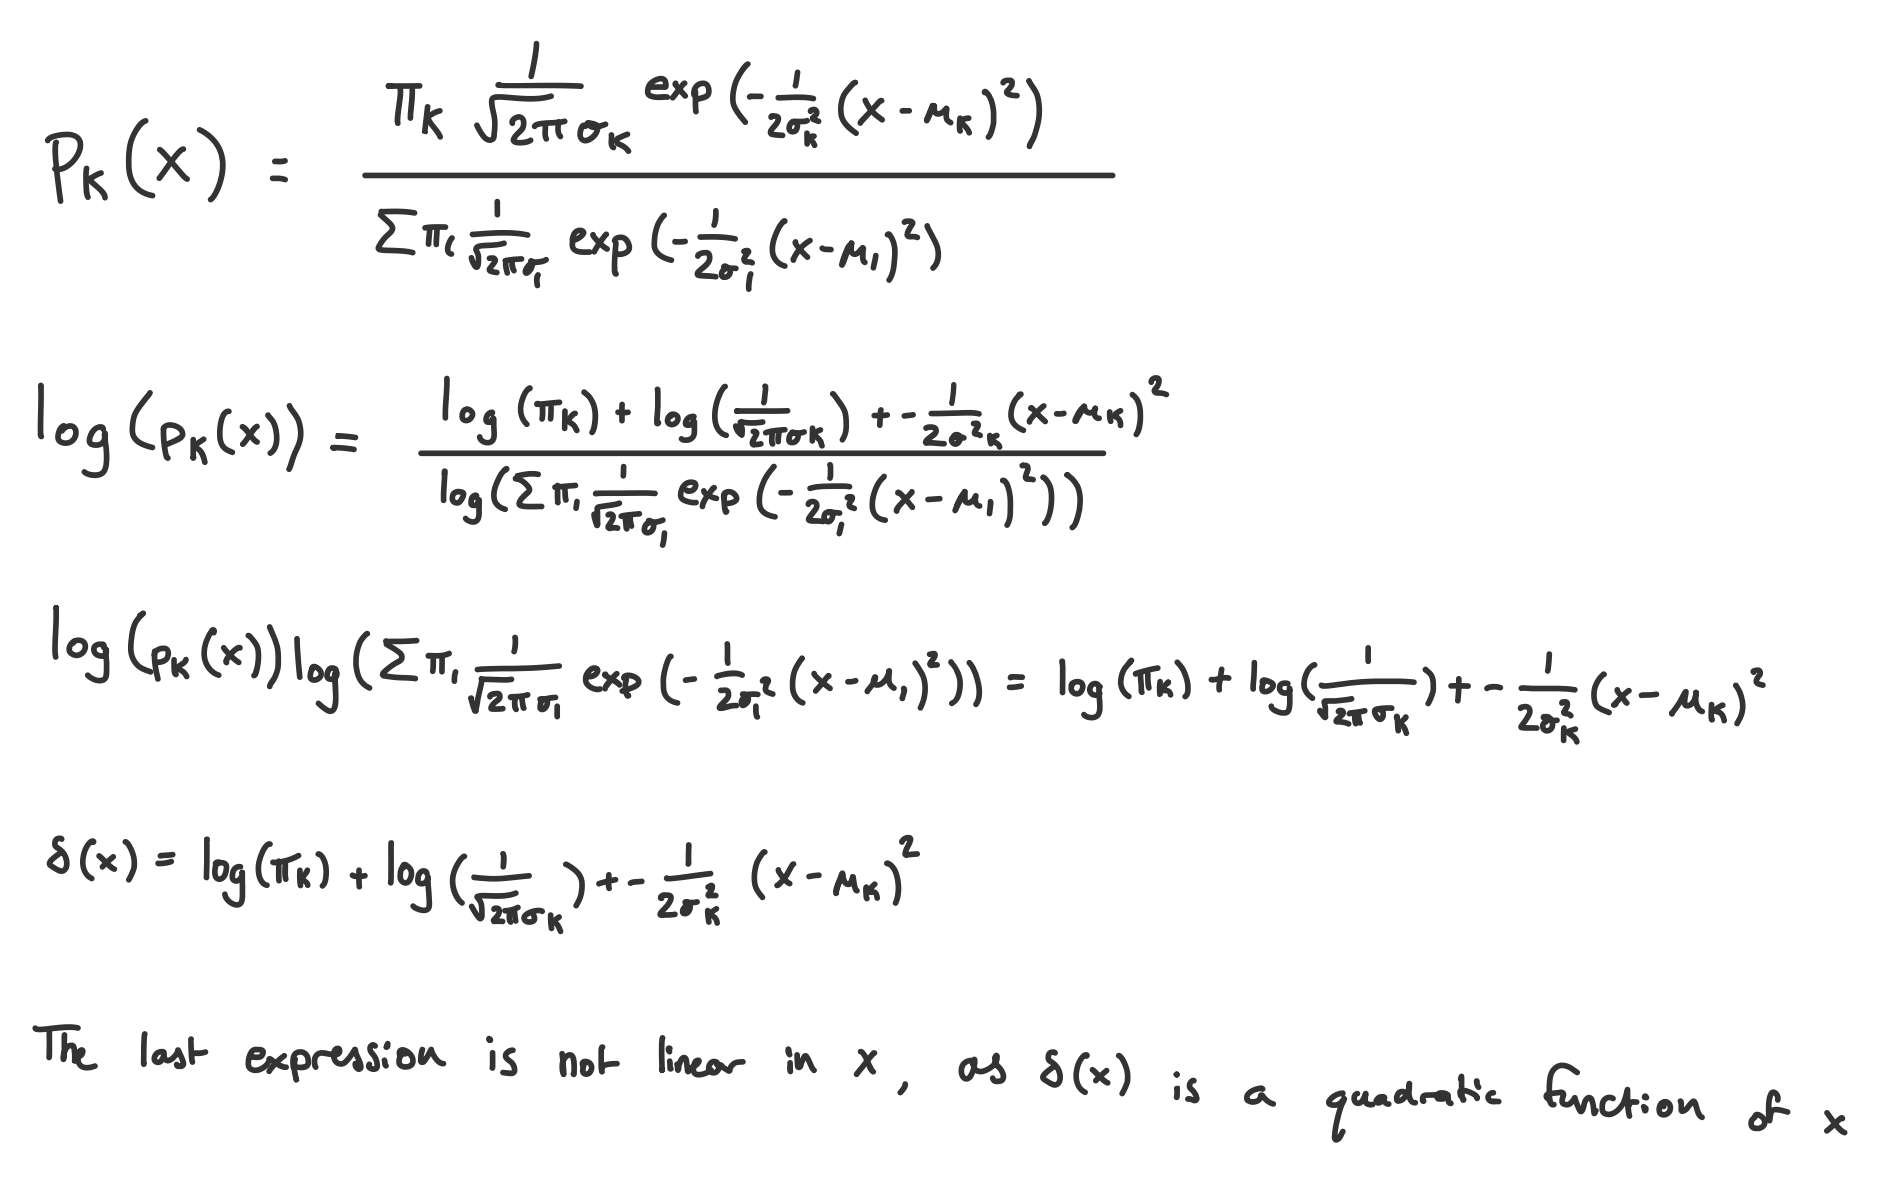

# Question (4)

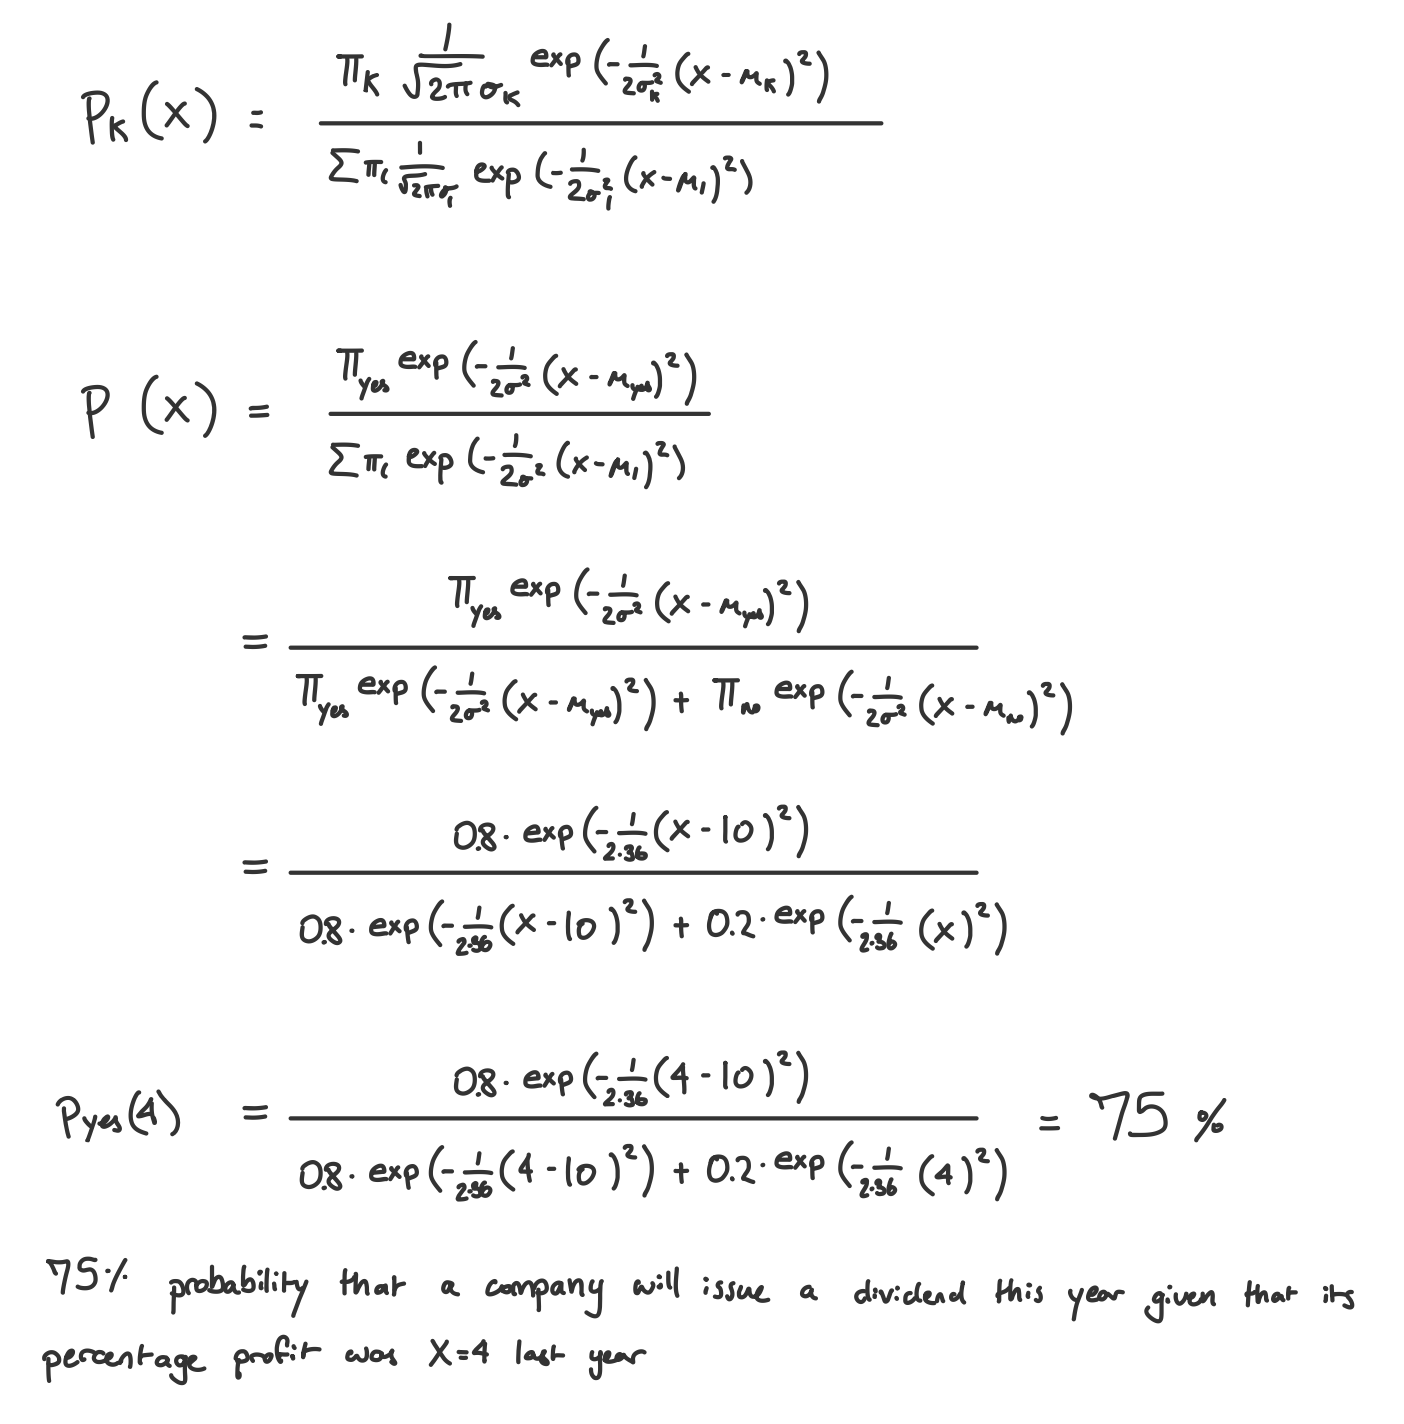